## Imports

In [210]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
import seaborn as sns


# Import libraries
from sklearn.tree import DecisionTreeClassifier  

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
import statsmodels.api as sm 
from sklearn.metrics import explained_variance_score  
from sklearn import preprocessing

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics


In [211]:
pd.options.mode.chained_assignment = None  # default='warn'

## Reading in Data

In [212]:
play_features = pd.read_csv('data/prepped/play_features.csv')
play_outcomes = pd.read_csv('data/prepped/play_outcomes.csv')

play_features['rating'] = play_outcomes['rating']
play_features['reviews'] = play_outcomes['reviews']
play_features['installs'] = play_outcomes['installs']

## Small Cleanup
We wanted to show the data distribution and needed to remove the '+' and making it a numeric

In [213]:
play_features['installs'] = play_features['installs'].map(lambda x: x.rstrip('+')).str.replace(',', '')
play_features['installs'] = pd.to_numeric(play_features['installs']) / 1000

In [214]:
play_features.head()

,app,category,size,type,price,content_rating,genres,last_updated,current_ver,android_min_ver,days_since_update,rating,reviews,installs
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,19000000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4_0_3,427.0,4.1,159,10.0
1,Coloring book moana,ART_AND_DESIGN,14000000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4_0_3,419.0,3.9,967,500.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87000000.0,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4_0_3,221.0,4.7,87510,5000.0
3,Sketch - Draw & Paint,ART_AND_DESIGN,25000000.0,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4_2,275.0,4.5,215644,50000.0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,28000000.0,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4_4,263.0,4.3,967,100.0


In [215]:
play_features.dtypes

app                   object
category              object
size                 float64
type                  object
price                float64
content_rating        object
genres                object
last_updated          object
current_ver           object
android_min_ver       object
days_since_update    float64
rating               float64
reviews                int64
installs             float64
dtype: object

In [216]:
dummy = pd.get_dummies(play_features['category']).astype(int)
result = pd.concat([play_features, dummy], axis=1, sort=False)


In [217]:
result.content_rating[result.content_rating == 'Teen'] = 13 
result.content_rating[result.content_rating == 'Everyone'] = 0
result.content_rating[result.content_rating == 'Everyone 10+'] = 10
result.content_rating[result.content_rating == 'Mature 17+'] = 17 
result.content_rating[result.content_rating == 'Adults only 18+'] = 18 
result.content_rating[result.content_rating == 'Unrated'] = -1

result['content_rating'] = result['content_rating'].astype(int)
result['content_rating'].unique()

array([ 0, 13, 10, 17, 18, -1], dtype=int64)

## Data Visualization
In order to get a feel for the data we visualized it

count    9360.000000
mean        4.191838
std         0.515263
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: rating, dtype: float64

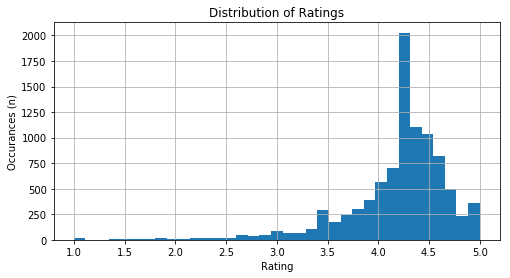

In [218]:
# Distribution of Ratings

plt.figure(figsize=(8,4))

play_features['rating'].hist(bins=35)

plt.xlabel('Rating');
plt.ylabel('Occurances (n)');
plt.title('Distribution of Ratings');

play_features['rating'].describe()

Most of the cells in the Distribution of Ratings follow a bell curve trend, however; when we reach a 5.0 rating it has a suddent spike. This may allude to market tampering and fake ratings.

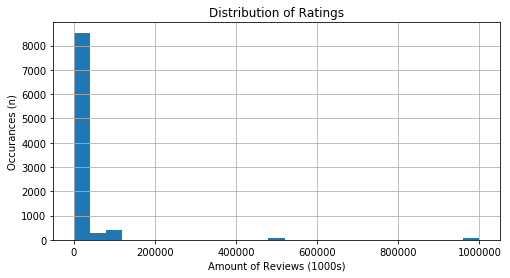

In [219]:
# Distribution of Reviews

plt.figure(figsize=(8,4))

play_features['installs'].hist(bins=25)

plt.xlabel('Amount of Reviews (1000s)');
plt.ylabel('Occurances (n)');
plt.title('Distribution of Ratings');

<Figure size 432x288 with 0 Axes>

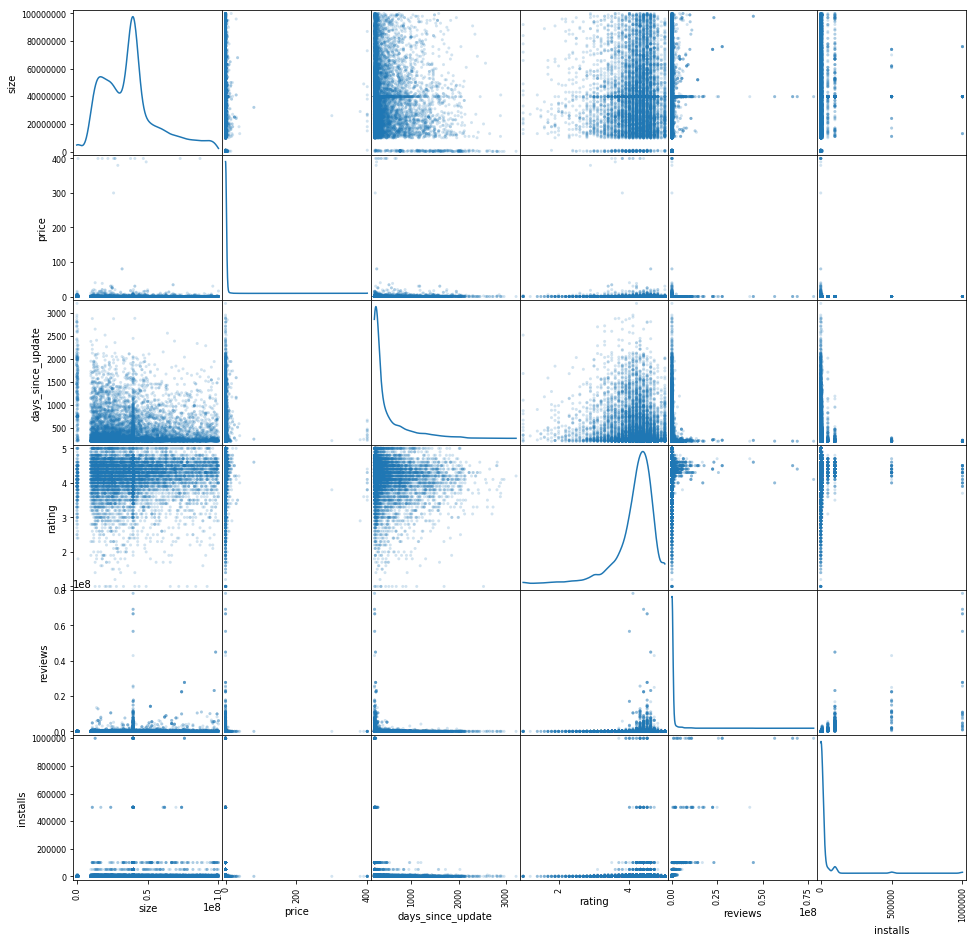

In [220]:
plt.figure()
pd.plotting.scatter_matrix(play_features, alpha=0.2, figsize=(16, 16), diagonal='kde')
plt.show()

## Correlations
Here we determine the correlations between each factor in order to see what is most important to look at

In [221]:
# Correlations
play_features.corr()

,size,price,days_since_update,rating,reviews,installs
size,1.000000,-0.011807,-0.168342,0.046426,0.072289,0.031949
price,-0.011807,1.000000,0.003964,-0.021919,-0.009824,-0.011895
days_since_update,-0.168342,0.003964,1.000000,-0.142966,-0.088182,-0.104371
rating,0.046426,-0.021919,-0.142966,1.000000,0.068133,0.051337
reviews,0.072289,-0.009824,-0.088182,0.068133,1.000000,0.641605
installs,0.031949,-0.011895,-0.104371,0.051337,0.641605,1.000000


In [222]:
# Correlation with category variables
result.corrwith(result.installs).sort_values(ascending=False)

installs               1.000000
reviews                0.641605
COMMUNICATION          0.170445
SOCIAL                 0.067313
GAME                   0.056194
rating                 0.051337
PRODUCTIVITY           0.048619
content_rating         0.045141
size                   0.031949
VIDEO_PLAYERS          0.030314
PHOTOGRAPHY            0.028548
NEWS_AND_MAGAZINES     0.024973
TRAVEL_AND_LOCAL       0.021518
ENTERTAINMENT          0.001878
TOOLS                 -0.007307
SHOPPING              -0.007544
BOOKS_AND_REFERENCE   -0.010855
price                 -0.011895
WEATHER               -0.012042
BEAUTY                -0.012703
EVENTS                -0.013369
PARENTING             -0.013881
ART_AND_DESIGN        -0.014086
COMICS                -0.014659
MAPS_AND_NAVIGATION   -0.015322
LIBRARIES_AND_DEMO    -0.015415
HOUSE_AND_HOME        -0.015556
AUTO_AND_VEHICLES     -0.016691
EDUCATION             -0.017471
FOOD_AND_DRINK        -0.018313
PERSONALIZATION       -0.021275
HEALTH_A

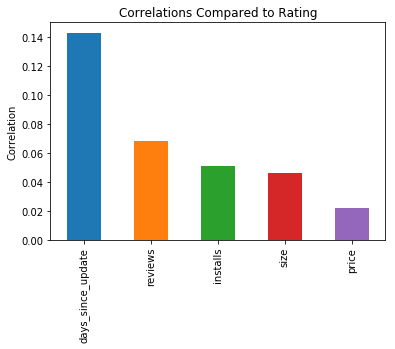

In [223]:
features_rating_corr = play_features.corr()['rating'].drop('rating')
plt.figure()
ax = features_rating_corr.abs().sort_values(ascending=False).plot('bar')
ax.set(title = 'Correlations Compared to Rating', ylabel = 'Correlation')
plt.show()

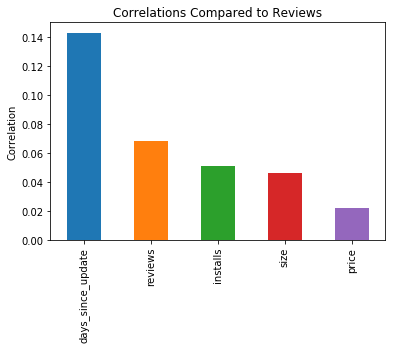

In [224]:
features_reviews_corr = play_features.corr()['reviews'].drop('reviews')
plt.figure()
ax = features_rating_corr.abs().sort_values(ascending=False).plot('bar')
ax.set(title = 'Correlations Compared to Reviews', ylabel = 'Correlation')
plt.show()

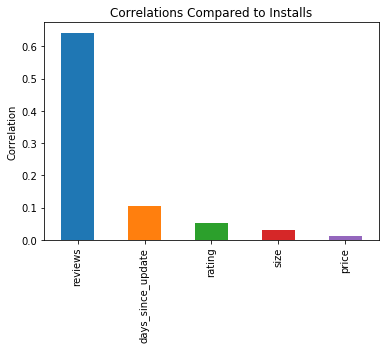

In [225]:
features_installs_corr = play_features.corr()['installs'].drop('installs')
plt.figure()
ax = features_installs_corr.abs().sort_values(ascending = False).plot('bar')
ax.set(title = 'Correlations Compared to Installs', ylabel = 'Correlation')
plt.show()

It appears most of these do not have a strong correlation to each other

In [226]:
f_sel = result.drop(['installs', 'app', 'category', 'type', 'genres', 'last_updated', 'current_ver', 'android_min_ver'], axis=1)

In [227]:
target = result.installs

## Feature Selection

In [228]:
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
target_encoded = lab_enc.fit_transform(target)

In [229]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=1000)
clf = clf.fit(f_sel, target_encoded)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(f_sel)
print("The new dataframe shape: ")
print(X_new.shape)     



The new dataframe shape: 
(9360, 5)


In [230]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = f_sel.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.reset_index()

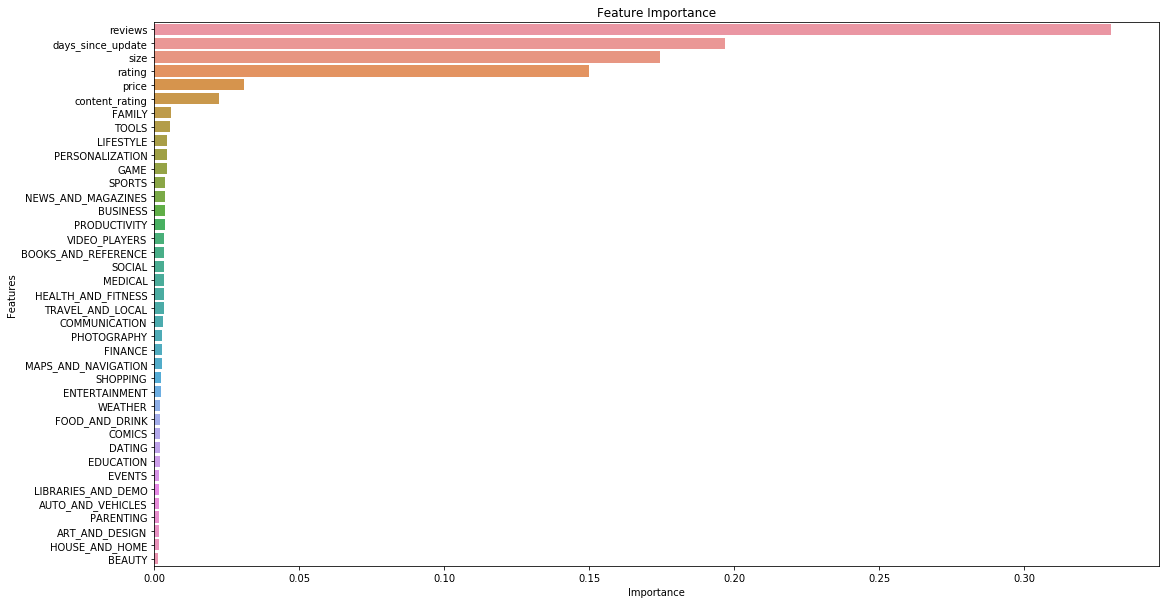

In [231]:
plt.figure(figsize=(18,10))
sns.barplot(x="importance", y="index", data=feature_importances)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [232]:
selected = f_sel[['reviews', 'days_since_update', 'size', 'rating', 'price']]

## Machine Learning

In [233]:
#create arrays for later comparison of model performance
acc = []
MAE = []
MSE = []
mdl = []

In [234]:

#create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(selected.astype(float), target_encoded, test_size=0.3)

In [235]:
from sklearn.model_selection import KFold, GridSearchCV

#create folds for future cross validation
folds = KFold(n_splits=5, shuffle=True, random_state=11)

In [236]:
#no normalization/standardization needed for RandomForest
pipe = make_pipeline(RandomForestClassifier())

param_grid = { 
    'randomforestclassifier__max_features': ['auto'],
    'randomforestclassifier__n_estimators': [500]
}

grid = GridSearchCV(pipe, param_grid, verbose=0, cv=folds, return_train_score=True) 
grid.fit(X_train, y_train)

predictions_2 = grid.predict(X_test)

print('Accuracy score: ' + str(accuracy_score(y_test, predictions_2)))
acc.append(accuracy_score(y_test, predictions_2))

print('MAE: ' + str(metrics.mean_absolute_error(y_test, predictions_2)))
MAE.append(metrics.mean_absolute_error(y_test, predictions_2))

print('MSE: ' + str(metrics.mean_squared_error(y_test, predictions_2)))
MSE.append(metrics.mean_squared_error(y_test, predictions_2))

mdl.append('RandomForestClassifier')

Accuracy score: 0.6082621082621082
MAE: 0.5124643874643875
MSE: 0.7831196581196581


In [237]:
# Scale values to use KNeighbors
pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

# Define a grid to search through
param_grid = {'kneighborsclassifier__n_neighbors':range(1, 100),
              'kneighborsclassifier__weights':["distance"]}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, verbose=0, cv=folds, return_train_score=True) 
grid.fit(X_train, y_train)

predictions_3 = grid.predict(X_test)

print('Accuracy score: ' + str(accuracy_score(y_test, predictions_3)))
acc.append(accuracy_score(y_test, predictions_3))

print('MAE: ' + str(metrics.mean_absolute_error(y_test, predictions_3)))
MAE.append(metrics.mean_absolute_error(y_test, predictions_3))

print('MSE: ' + str(metrics.mean_squared_error(y_test, predictions_3)))
MSE.append(metrics.mean_squared_error(y_test, predictions_3))

mdl.append('KNeighborsClassifier')

Accuracy score: 0.34793447293447294
MAE: 1.8849715099715099
MSE: 7.705484330484331


In [238]:
print('The parameters selected to use in this model:')
print(grid.best_params_)

The parameters selected to use in this model:
{'kneighborsclassifier__n_neighbors': 31, 'kneighborsclassifier__weights': 'distance'}


In [239]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost


In [240]:
pipe = make_pipeline(XGBClassifier())

param_grid = {
              'xgbclassifier__min_child_weight': [1],
              'xgbclassifier__n_estimators': [500],
              'xgbclassifier__max_depth': [9],
              'xgbclassifier__learning_rate': [.03],
              'xgbclassifier__subsample': [.9],

             }

grid = GridSearchCV(pipe, param_grid, verbose=0, cv=folds, return_train_score=True) 
grid.fit(X_train, y_train)

predictions_5 = grid.predict(X_test)

print('Accuracy score: ' + str(accuracy_score(y_test, predictions_5)))
acc.append(accuracy_score(y_test, predictions_5))

print('MAE: ' + str(metrics.mean_absolute_error(y_test, predictions_5)))
MAE.append(metrics.mean_absolute_error(y_test, predictions_5))

print('MSE: ' + str(metrics.mean_squared_error(y_test, predictions_5)))
MSE.append(metrics.mean_squared_error(y_test, predictions_5))

mdl.append('XGBClassifier')

Accuracy score: 0.5915242165242165
MAE: 0.5359686609686609
MSE: 0.8315527065527065


## Machine Learning Results

In [241]:
model_array = []
for i in range(len(mdl)): 
    model_dict = {'model': mdl[i], 'MSE': MSE[i], 
                'MAE': MAE[i], 'Accuracy': acc[i]} 
    model_array.append(model_dict) 
model_df = pd.DataFrame(data = model_array) 

In [242]:
mae_df = model_df.drop(['MSE', 'Accuracy'], axis=1)
mse_df = model_df.drop(['MAE', 'Accuracy'], axis=1)
acc_df = model_df.drop(['MAE', 'MSE'], axis=1)

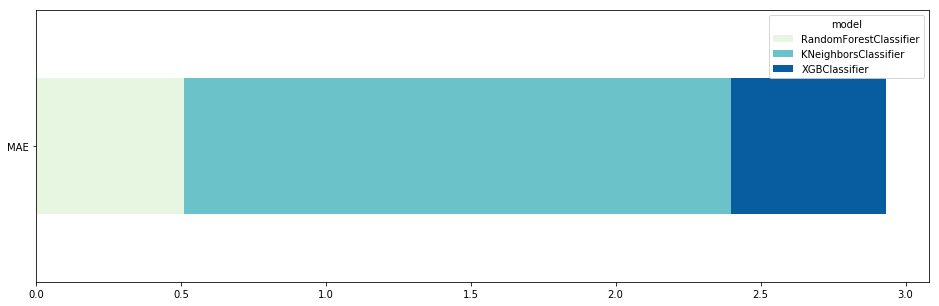

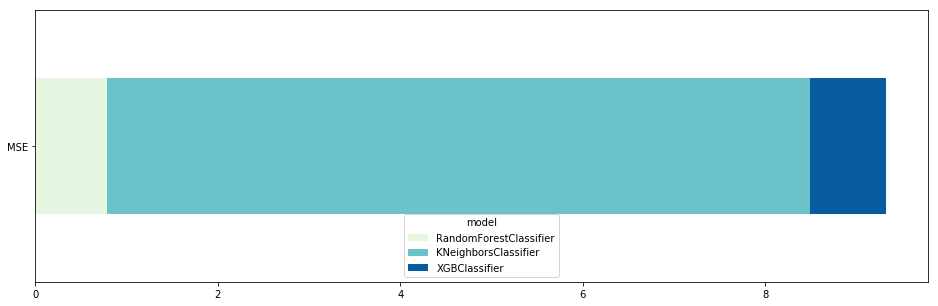

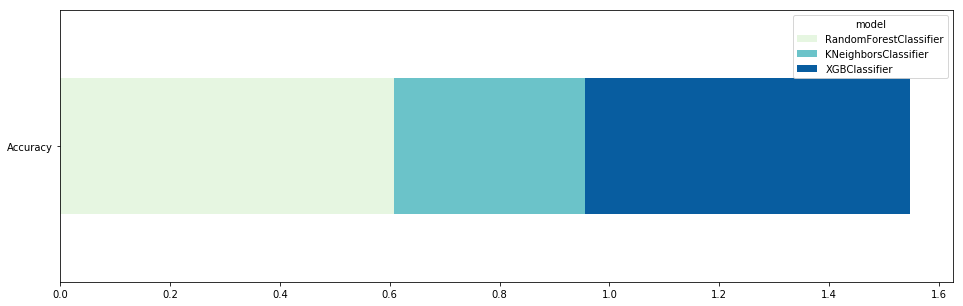

In [243]:
from matplotlib.colors import ListedColormap

mae_df.set_index('model').reindex(mae_df.set_index('model').sum().sort_values().index,
                            axis=1).T.plot(kind='barh', stacked=True,
                                           colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(16,5))

mse_df.set_index('model').reindex(mse_df.set_index('model').sum().sort_values().index,
                            axis=1).T.plot(kind='barh', stacked=True,
                                           colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(16,5))

acc_df.set_index('model').reindex(acc_df.set_index('model').sum().sort_values().index,
                            axis=1).T.plot(kind='barh', stacked=True,
                                           colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(16,5))

In [244]:
model_df

,Accuracy,MAE,MSE,model
0,0.608262,0.512464,0.783120,RandomForestClassifier
1,0.347934,1.884972,7.705484,KNeighborsClassifier
2,0.591524,0.535969,0.831553,XGBClassifier


In [245]:
y_slice = y_test[500:750]
prd3_slice = predictions_3[500:750]
num = list(range(250))

### Prediction Accuracy Across the Models

The line graphs in this section show the accuracy of the predictions across the models.

Text(0, 0.5, 'Installations')

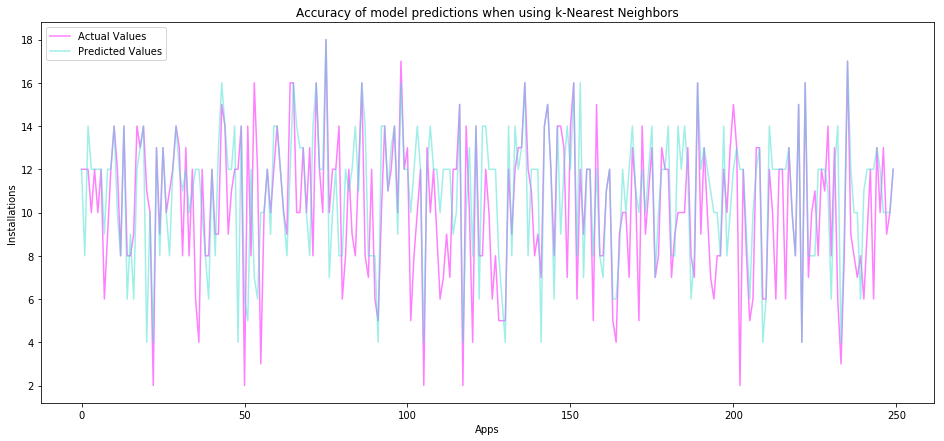

In [251]:
plt.figure(figsize=(16,7))
plt.plot(num, y_slice, alpha = .5, color = 'magenta', label = 'Actual Values')
plt.plot(num, prd3_slice, alpha = .5,  color='turquoise', label = 'Predicted Values')
plt.title('Accuracy of model predictions when using k-Nearest Neighbors')
plt.legend(loc='upper left')
plt.xlabel('Apps')
plt.ylabel('Installations')

In [247]:
prd2_slice = predictions_3[500:750]

Text(0, 0.5, 'Installations')

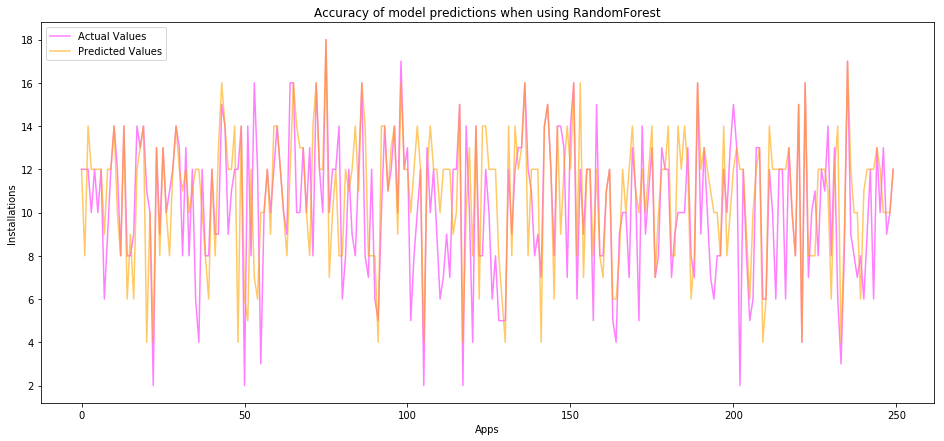

In [252]:
plt.figure(figsize=(16,7))
plt.plot(num, y_slice, alpha = .5, color = 'magenta',  label = 'Actual Values')
plt.plot(num, prd2_slice, alpha = .6, color='orange', label = 'Predicted Values')
plt.title('Accuracy of model predictions when using RandomForest')
plt.legend(loc='upper left')
plt.xlabel('Apps')
plt.ylabel('Installations')

In [249]:
prd5_slice = predictions_3[500:750]

Text(0, 0.5, 'Installations')

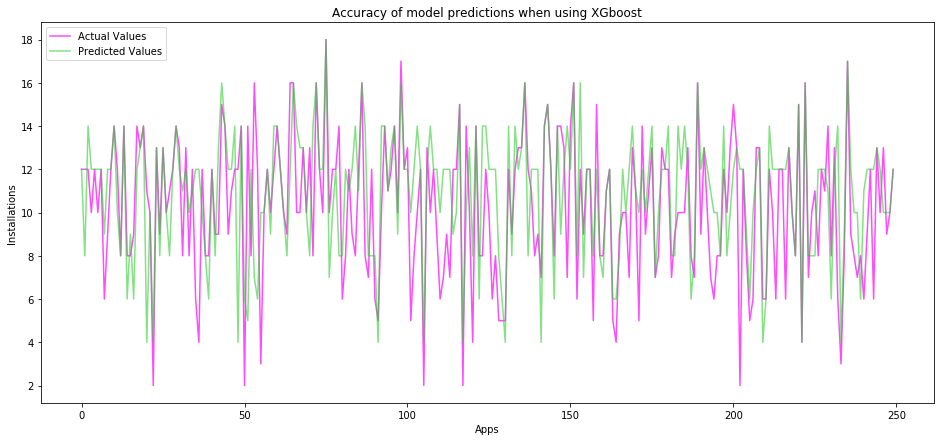

In [253]:
plt.figure(figsize=(16,7))
plt.plot(num, y_slice, alpha = .7, color = 'magenta', label = 'Actual Values')
plt.plot(num, prd5_slice, alpha = .6, color = 'limegreen', label = 'Predicted Values')
plt.title('Accuracy of model predictions when using XGboost')
plt.legend(loc='upper left')
plt.xlabel('Apps')
plt.ylabel('Installations')